# Red Light, Green Light: Dynamic Traffic Lights with RL
## By Erin Gregoire & Daniel Viola
### Spring 2025

In [9]:
import gymnasium as gym
from gymnasium import spaces
import sumo_rl
import os
os.environ["SUMO_HOME"] = r"C:\Program Files (x86)\Eclipse\Sumo"
from sumo_rl.environment.observations import ObservationFunction
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import traci
import torch
import random
import copy
import torch.optim as optim
from torch import nn
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

In [2]:
class CustomObservation(ObservationFunction):
    def __init__(self, ts):
        super().__init__(ts)

    def __call__(self) -> np.ndarray:
        phase_id = [1 if self.ts.green_phase == i else 0 for i in range(self.ts.num_green_phases)]
        queue = self.ts.get_lanes_queue()
        queue_buckets = []
        for i in queue:
            if i < .1:
                queue_buckets.append(1)
            elif .1 <= i < .2:
                queue_buckets.append(2)
            elif .2 <= i < .3:
                queue_buckets.append(3)
            elif .3 <= i < .4:
                queue_buckets.append(4)
            elif .4 <= i < .5:
                queue_buckets.append(5)
            elif .5 <= i < .6:
                queue_buckets.append(6)
            elif .6 <= i < .7:
                queue_buckets.append(7)
            elif .7 <= i < .8:
                queue_buckets.append(8)
            elif .8 <= i < .9:
                queue_buckets.append(9)
            else:
                queue_buckets.append(10)
        observation = np.array(phase_id + queue_buckets, dtype=np.float32)
        return observation

    def observation_space(self) -> spaces.Box:
        return spaces.Box(
            low=np.zeros(self.ts.num_green_phases + len(self.ts.lanes), dtype=np.float32),
            high=np.ones(self.ts.num_green_phases + len(self.ts.lanes), dtype=np.float32),)

In [3]:
class AverageWaitCallback(BaseCallback):
    def __init__(self, verbose: int = 1):
        super().__init__(verbose)
        self.average_wait_per_car = []
        self.departed_total = 0
        self.waiting_times = []
        self.system_total_waiting_time = 0
    
    def _on_step(self):
        for info in self.locals['infos']:
            self.system_total_waiting_time = info["system_total_waiting_time"]
            self.waiting_times.append(self.system_total_waiting_time)
            step_departed = traci.simulation.getDepartedNumber()
            self.departed_total += step_departed

        if 'done' in self.locals:
            if self.locals.get('done', True):
                end_wait_time = self.waiting_times[-2]
                self.average_wait_per_car.append(end_wait_time / max(self.departed_total, 1))
                
                self.departed_total = 0 # reset at end of episode
                self.system_total_waiting_time = 0
                self.waiting_times = []
        return True

    def _on_training_end(self):
        # plot average wait time at end of training
        plt.figure()
        plt.plot(self.average_wait_per_car)
        plt.xlabel('Episode', fontsize=20)
        plt.ylabel('Wait Time (sec)', fontsize=20)
        plt.title('Average Wait Time Per Episode', fontsize=24)
        plt.xticks(fontsize=18)
        plt.ylim(ymin=(min(self.average_wait_per_car)-5), ymax=(max(self.average_wait_per_car)+5))
        plt.grid()
        plt.show()
        return True

Output()

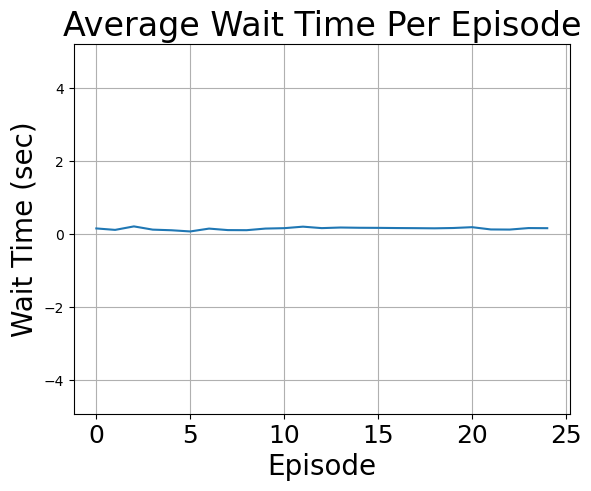

In [7]:
def looping_time(): # 2 way single intersection
    steps = 40000
    env = gym.make("sumo-rl-v0",
        net_file=r"C:\Users\egreg\Documents\Reinforcement Learning\Final Project\intersection_data\single-intersection.net.xml",
        route_file=r"C:\Users\egreg\Documents\Reinforcement Learning\Final Project\intersection_data\single-intersection-gen.rou.xml",
        use_gui=False,
        single_agent=True,
        out_csv_name="ppo_results_single_intersection",
        observation_class=CustomObservation,
        num_seconds=steps)
    env = Monitor(env, filename="ppo_single_intersection")
    agent=PPO("MlpPolicy", env, learning_rate=.0001, verbose=0, device="cpu", n_steps=128)
    
    agent.learn(total_timesteps=200000, callback=AverageWaitCallback(), progress_bar=True)
    agent.save("ppo_single_intersection")
        
looping_time()

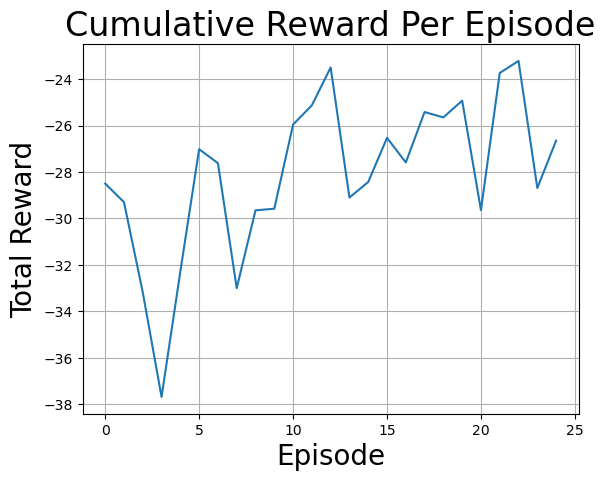

In [11]:
# graph cumulative rewards per episode
df = pd.read_csv("ppo_single_intersection.monitor.csv", skiprows=1)
plt.figure()
plt.plot(df["r"])
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Total Reward', fontsize=20)
plt.title('Cumulative Reward Per Episode', fontsize=24)
plt.grid()
plt.show()

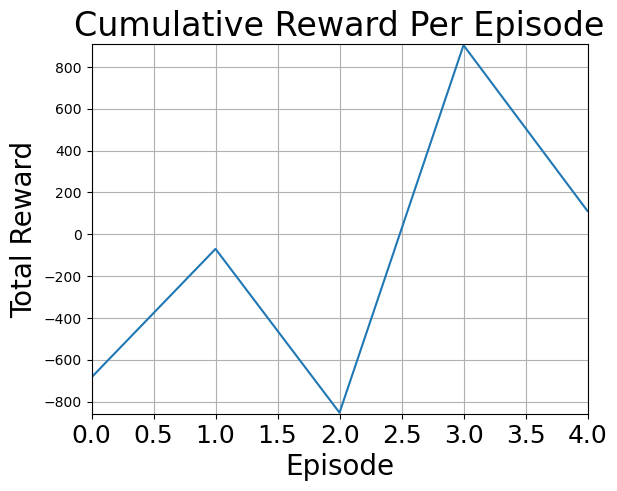

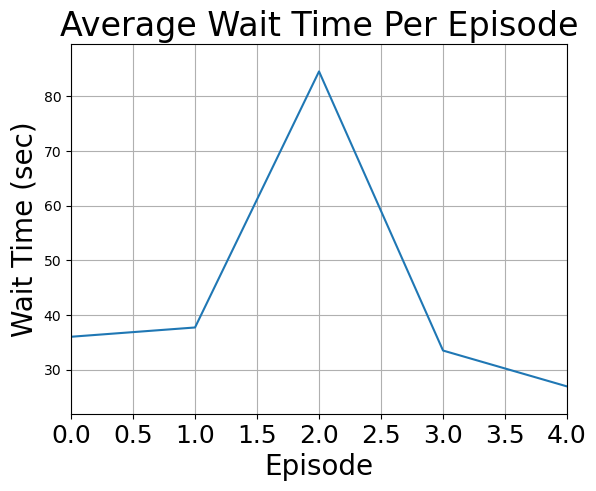

In [152]:
def eval_looping_time(): # 2 way single intersection
    steps = 120
    env = gym.make("sumo-rl-v0",
        net_file=r"C:\Users\egreg\Documents\Reinforcement Learning\Final Project\intersection_data\single-intersection.net.xml",
        route_file=r"C:\Users\egreg\Documents\Reinforcement Learning\Final Project\intersection_data\single-intersection-gen.rou.xml",
        out_csv_name="ppo_results_single_intersection_evaluation",
        use_gui=False,
        single_agent=True,
        observation_class=CustomObservation,
        num_seconds=steps)
    agent = PPO.load("ppo_single_intersection")
    episodes = 5
    cumulative_rewards = []
    previous_wait = 0
    current_wait = 0
    average_wait_per_car = []

    for i in range(episodes):
            ep_reward = 0
            departed_total = 0
            obs, info = env.reset()
            
            terminated, truncated = False, False
            while not (terminated or truncated):
                action, _states = agent.predict(obs)
                next_obs, reward, terminated, truncated, info = env.step(action)
                current_wait = info.get("system_total_waiting_time", 0)
                reward = previous_wait - current_wait
                previous_wait = current_wait
                departed_total += traci.simulation.getDepartedNumber()
                ep_reward += reward
                obs = next_obs
            cumulative_rewards.append(ep_reward)
            average_wait_per_car.append(info["system_total_waiting_time"] / max(departed_total, 1))

    # total reward per episode
    plt.figure()
    plt.plot(cumulative_rewards)
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Total Reward', fontsize=20)
    plt.title('Cumulative Reward Per Episode', fontsize=24)
    plt.xticks(fontsize=18)
    plt.ylim(ymin=(min(cumulative_rewards)-5), ymax=(max(cumulative_rewards)+5))
    plt.xlim(xmin=0, xmax=episodes-1)
    plt.grid()
    plt.show()

    # average wait per vehicle
    plt.figure()
    plt.plot(average_wait_per_car)
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Wait Time (sec)', fontsize=20)
    plt.title('Average Wait Time Per Episode', fontsize=24)
    plt.xticks(fontsize=18)
    plt.ylim(ymin=(min(average_wait_per_car)-5), ymax=(max(average_wait_per_car)+5))
    plt.xlim(xmin=0, xmax=episodes-1)
    plt.grid()
    plt.show()     

eval_looping_time()